<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#1ee353;
            overflow:hidden;
            font-weight:500"> RAG - Langchain Ragas</div>

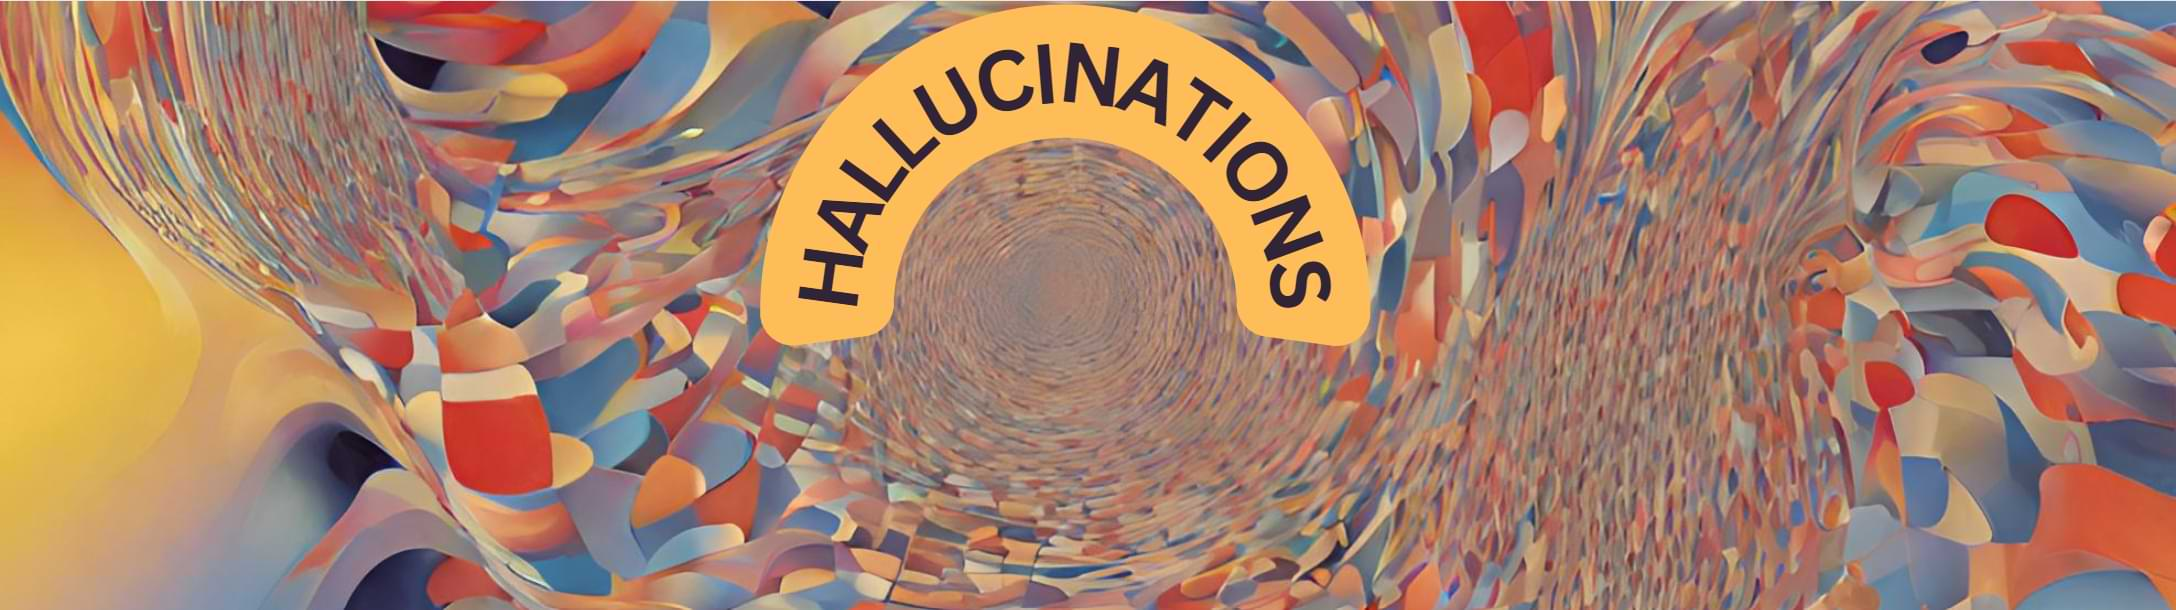

  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>INTRODUCTION</b>
  </div>

This notebook contains a full Q&A pipeline using langchain framework, FAISS as vector database and RAGAS as evaluation metrics. The data used is the Hallucinations Leaderboard from **[HuggingFace](https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations)**. 

The main steps taken to build the RAG pipeline can be summarize as follows (a basic RAG Pipeline is performed after text cleaning):

* **Model Definition**: model class definition

* **Data Ingestion**: load data from website

* **Instantiation**: model llama2-7b or falcon-7b-v2

* **Indexing**: RecursiveCharacterTextSplitter for indexing in chunks

* **Embedding**: HuggingFaceBgeEmbeddings BAAI/bge-large-en-v1.5

* **QA Chain Retrieval**: HuggingFacePipeline and RetrievalQA

* **Scoring**: top k most similar results

* **Evaluation**: TestsetGenerator from RAGAS and evaluation with answer_relevancy, context_recall, context_precision, and answer_correctness

  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>CONTACT INFORMATION</b>
  </div>

If you like this project, feel free to star my repository, copy this notebook an make your own RAG Project. You can also contact me through LinkedIn, follow my GitHub or check my Website

**Benito Martin:** 

- [GitHub](https://github.com/benitomartin) 🔗

- [LinkedIn](https://www.linkedin.com/in/benitomzh/) 🔗

- [Website](https://benitomartin.github.io/) 🔗

  <div style="padding:20px; 
              color:blue;
              margin:10px;
              font-size:150%;
              text-align:center;
              display:fill;
              border-radius:20px;
              border-width: 5px;
              background-color:#eca912;
              overflow:hidden;
              font-weight:500">
    <b>TABLE OF CONTENTS</b>
  </div>

* [1. Dependencies](#dep)

    * [1.1. Installations](#ins)
    * [1.2. Import Libraries](#lib)
    * [1.3. Mount Drive](#drv)
    * [1.4. API Keys](#key)
   
* [2. Model Definition](#mod)  

* [3. FAISS RAG Pipeline](#faiss)
   
    * [3.1. Data Ingestion](#get)           

    * [3.2. Indexing](#ind)    

        * [3.2.1. Instantiate the Model](#ins)

        * [3.2.2. Splitting](#split)
        
        * [3.2.3. Embedding](#emb)
        
        * [3.2.4. Vector Store](#vec)

    * [3.3. QA Chain Retrieval](#qa)

* [4. Model Evaluation](#eval)
 
    * [4.1. Similarity](#sim)

    * [4.2. Ragas](#ragas)
 
* [5. Further Steps](#steps)

# <font color='289C4E'>1. Dependencies 📚<font><a class='anchor' id='dep'></a>

## <font color='289C4E'>1.1.  Installations 📑<font><a class='anchor' id='ins'></a>

In [ ]:
!pip install -U -qq tiktoken cohere openai

In [ ]:
!pip install -U -qq torch==2.1.2 torchvision torchaudio torchtext

In [ ]:
!pip install -U -qq langchain pypdf faiss-gpu
!pip install -U -qq transformers InstructorEmbedding sentence_transformers
!pip install -U -qq huggingface-hub accelerate bitsandbytes xformers einops

In [ ]:
# # Might be necessary if the encoding is not UTF-8 and get an error by installing ragas
# print(locale.getpreferredencoding())

# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# print(locale.getpreferredencoding())

!pip install -U -qq ragas

## <font color='289C4E'>1.2. Import Libraries 📑<font><a class='anchor' id='lib'></a>

In [ ]:
# Global
import os
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from datasets import Dataset
from google.colab import userdata

# Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# OpenAI
from openai import OpenAI

# Langchain
from langchain_community.document_loaders import WebBaseLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain.chains import RetrievalQA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import HuggingFacePipeline
from langchain.callbacks import StdOutCallbackHandler

# Ragas
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from ragas import evaluate

# Warnings
import warnings
warnings.filterwarnings("ignore")

## <font color='289C4E'>1.3. Mount Drive 📖<font><a class='anchor' id='drv'></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color='289C4E'>1.4. Get API Keys 🗝️<font><a class='anchor' id='keys'></a>

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# <font color='289C4E'>2. Model Definition 🧹<font><a class='anchor' id='mod'></a>

The approach taken for the pipeline has been to create model functions with all the parameters, which will allow to instanciate several models with its hyperparameters.

In [ ]:
# Creating a Model Class

class Model:
    def __init__(self, model_name ='llama2-7b', temperature = 0,
                 top_p = 0.95, repetition_penalty = 1.15,
                 split_chunk_size = 512, split_overlap = 16, k = 3,
                 embeddings_path = "./faiss_index_hp",
                 persist_directory = "./faiss-vectordb"):

        """
        Initialize the Model class with default values and parameters.
        :param model_name: Name of the model (default: 'llama2-7b')
        :param temperature: Controls the randomness of the predictions (default: 0)
        :param top_p: Top p value for nucleus sampling (default: 0.95)
        :param repetition_penalty: Penalty for repeated tokens (default: 1.15)
        :param split_chunk_size: Size of chunks to split the input text (default: 800)
        :param split_overlap: Overlap between split chunks (default: 0)
        :param k: Value for some parameter 'k' (default: 3)
        """

        # Parameters
        self.model_name = model_name
        self.temperature = temperature
        self.top_p = top_p
        self.repetition_penalty = repetition_penalty
        self.split_chunk_size = split_chunk_size
        self.split_overlap = split_overlap
        self.embeddings_model_repo = 'BAAI/bge-large-en-v1.5'
        self.k = k
        self.embeddings_path = embeddings_path
        self.persist_directory = persist_directory

In [ ]:
# Getting the Model

def get_model(config):
    # Extract the model name from the configuration
    model_name = config.model_name

    # Dictionary containing model parameters
    model_params = {
        'llama2-7b': {
            'repo': 'daryl149/llama-2-7b-chat-hf',
            'max_len': 2048,
            'extra_params': {
                'load_in_4bit': True,
                'device_map': 'auto',
                'torch_dtype': torch.float16,
                'low_cpu_mem_usage': True,
                'trust_remote_code': True
            }
        },
        'falcon': {
            'repo': 'h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2',
            'max_len': 1024,
            'extra_params': {
                'load_in_4bit': True,
                'device_map': 'auto',
                'torch_dtype': torch.float16,
                'low_cpu_mem_usage': True,
                'trust_remote_code': True
            }
        },
    }

    # Check if the provided model name exists in the predefined model parameters
    if model_name in model_params:
        # Get the parameters for the specified model
        params = model_params[model_name]
        model_repo = params['repo']

        # Extract any additional parameters specific to the model
        extra_params = params.get('extra_params', {})

        # Instantiate a tokenizer based on the model repository and extra parameters
        tokenizer = AutoTokenizer.from_pretrained(model_repo, **extra_params)

        # Instantiate the model for causal language modeling
        model = AutoModelForCausalLM.from_pretrained(model_repo, **extra_params)

        # Get the maximum length for the model
        max_len = params['max_len']
    else:
        # Raise an error if the provided model is not implemented in the dictionary
        raise ValueError("The provided model is not implemented.")

    # Return the instantiated tokenizer, model, and maximum length
    return tokenizer, model, max_len


# <font color='289C4E'>3. FAISS RAG Pipeline 📳<font><a class='anchor' id='faiss'></a>

## <font color='289C4E'>3.1. Data Ingestion 🎡<font><a class='anchor' id='get'></a>

The first step is to get our data. We will use the **WebBaseLoader**, and select the website to be loaded.

In [ ]:
# Load the data

loader = WebBaseLoader(
    "https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations"
)

documents = loader.load()

In [ ]:
# Save the loaded documents using pickle

with open('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/loaded_documents.pkl', 'wb') as file:
    pickle.dump(documents, file)


In [ ]:
# Load the saved documents

with open('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/loaded_documents.pkl', 'rb') as file:
    documents = pickle.load(file)


## <font color='289C4E'>3.2. Indexing 🌊<font><a class='anchor' id='ind'></a>

In order to create the index there are several steps to follow:
- Select a splitting method and its hyperparameters: we will use the **RecursiveCharacterTextSplitter**. Recursively tries to split by different characters to find one that works.

- Select the embeddings model: in our case the **BAAI/bge-large-en-v1.5**.

- Select a Vector Store: **FAISS**.



### <font color='289C4E'>3.2.1. Instantiate the model 🔠<font><a class='anchor' id='ins'></a>

We have to instatiate the model in order to pass the corresponding hyperparameters.

In [ ]:
# Creating an instance of the Model Class and get the model

my_faiss_model = Model(model_name="llama2-7b",
                       embeddings_path = "/faiss_index_hp",
                       persist_directory = "./faiss-vectordb")

tokenizer, model_faiss, max_len = get_model(config=my_faiss_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### <font color='289C4E'>3.2.2 Splitting 🪓<font><a class='anchor' id='split'></a>

In [ ]:
# Instantiate a RecursiveCharacterTextSplitter using parameters from 'my_model'

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=my_faiss_model.split_chunk_size,  # Set the size of each text chunk
    chunk_overlap=my_faiss_model.split_overlap   # Set the overlap between consecutive chunks
)

# Split the documents into smaller texts using the text splitter
splitted_text = text_splitter.split_documents(documents)

# Print the number of resulting text chunks
print(f'Number of Chunks: {len(splitted_text)}')

# Print the number of original pages/documents
print(f'Number of Pages: {len(documents)}')

Number of Chunks: 57
Number of Pages: 1


### <font color='289C4E'>3.2.3. Embedding 🪟<font><a class='anchor' id='emb'></a>

In [ ]:
# Download embeddings model

embeddings = HuggingFaceBgeEmbeddings(
    model_name = my_faiss_model.embeddings_model_repo,
    model_kwargs = {"device": "cuda"},
    encode_kwargs = {"normalize_embeddings": True}
)

### <font color='289C4E'>3.2.4. Vector Store 🗂️<font><a class='anchor' id='vec'></a>

In [ ]:
# Create the vector store

faiss_vectordb = FAISS.from_documents(
                documents = splitted_text,
                embedding = embeddings
                )

## <font color='289C4E'>3.3. QA Chain Retrieval 🚒<font><a class='anchor' id='qa'></a>

Next,  we need to create our retrieval pipeline and in order to augment the prompt with the additional context, we need to prepare a prompt template. The prompt can be easily customized from a prompt template, as shown below. The pipeline will be created with **HuggingFacePipeline**.

In [ ]:
# Retrieval pipeline
pipe = pipeline(
      task="text-generation",
      model=model_faiss,
      tokenizer=tokenizer,
      pad_token_id=tokenizer.eos_token_id,
      max_length=max_len,
      temperature=my_faiss_model.temperature,
      top_p=my_faiss_model.top_p,
      repetition_penalty=my_faiss_model.repetition_penalty
  )

# Creating the Hugging Face pipeline
llm = HuggingFacePipeline(pipeline=pipe)

# Corvert the vector store in a retriever
retriever = faiss_vectordb.as_retriever(search_type="similarity", search_kwargs={"k": my_faiss_model.k})

# Set prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.

Question: {question}
Context: {context}

Answer:
"""

prompt = ChatPromptTemplate.from_template(template)


# Set the question
question = "What are hallucinations in the context of LLM models?"

# Callback: helps to show and manage the output
handler =  StdOutCallbackHandler()

# Initializing a combined QA chain
qa_combined_chain = RetrievalQA.from_chain_type(
                    llm=llm,
                    chain_type_kwargs = {"prompt": prompt},
                    retriever=retriever,
                    callbacks=[handler],
                    return_source_documents=True)

# Initialize the query
response = qa_combined_chain({"query": question, "context": retriever})

# Print response
response["result"]



> Entering new RetrievalQA chain...

> Finished chain.


"Hallucinations in the context of LLMs refer to instances where the model generates content that does not align with real-world facts or the user's input. This can lead to unreliable and unfaithful language generation, which can negatively impact the effectiveness of LLMs in various applications. To address this challenge, the Hallucinations Leaderboard was created as an open effort to evaluate and compare different LLMs based on their tendency to generate hallucinated content. By providing insights into the generalization properties and limitations of these models, the leaderboard aims to support the development of more reliable and accurate language generators."

In [ ]:
response["source_documents"]

[Document(page_content='The Hallucinations Leaderboard is an open effort to address the challenge of hallucinations in LLMs. Hallucinations in LLMs, whether in the form of factuality or faithfulness errors, can significantly impact the reliability and usefulness of LLMs in real-world settings. By evaluating a diverse range of LLMs across multiple benchmarks, the Hallucinations Leaderboard aims to provide insights into the generalisation properties and limitations of these models and their tendency to generate hallucinated', metadata={'source': 'https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations', 'title': 'The Hallucinations Leaderboard, an Open Effort to Measure Hallucinations in Large Language Models', 'description': 'We’re on a journey to advance and democratize artificial intelligence through open source and open science.', 'language': 'No language found.'}),
 Document(page_content="In the rapidly evolving field of Natural Language Processing (NLP), Large Language M

# <font color='289C4E'>4. Model Evaluation ❓<font><a class='anchor' id='eval'></a>

## <font color='289C4E'>4.1. Similarity 🤼‍♂️<font><a class='anchor' id='sim'></a>

There are some FAISS specific methods to check the similarity. One of them is **similarity_search_with_score** ( search for the top k most similar vectors to the query vector), which allows you to return not only the documents but also the distance score of the query to them. The returned distance score is L2 distance. Therefore, a lower score close to 0 is better.

In [ ]:
### Testing Similarity Search

# Set the question
question = "What are hallucinations in the context of LLM models?"

results_with_scores = faiss_vectordb.similarity_search_with_score(question, k = my_faiss_model.k)

for doc, score in results_with_scores:
    metadata = doc.metadata if hasattr(doc, 'metadata') else None
    source = metadata.get('source') if metadata else None
    # title = metadata.get('title') if metadata else None

    print(f"Source: {source}, Score: {score}")

Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.41722849011421204
Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.424437552690506
Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.4498262107372284


In [ ]:
results_with_scores

[(Document(page_content='The Hallucinations Leaderboard is an open effort to address the challenge of hallucinations in LLMs. Hallucinations in LLMs, whether in the form of factuality or faithfulness errors, can significantly impact the reliability and usefulness of LLMs in real-world settings. By evaluating a diverse range of LLMs across multiple benchmarks, the Hallucinations Leaderboard aims to provide insights into the generalisation properties and limitations of these models and their tendency to generate hallucinated', metadata={'source': 'https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations', 'title': 'The Hallucinations Leaderboard, an Open Effort to Measure Hallucinations in Large Language Models', 'description': 'We’re on a journey to advance and democratize artificial intelligence through open source and open science.', 'language': 'No language found.'}),
  0.4172285),
 (Document(page_content="In the rapidly evolving field of Natural Language Processing (NLP), 

Another metric is the **similarity_search_with_relevance_scores**. This metric is normalize from 0 to 1. Therefore, a higher score close to 1 the better.

In [ ]:
### Testing Similarity Search with relevance

question = "What are hallucinations in the context of LLM models?"

results_with_scores = faiss_vectordb.similarity_search_with_relevance_scores(question, k = my_faiss_model.k)


for doc, score in results_with_scores:
    metadata = doc.metadata if hasattr(doc, 'metadata') else None
    source = metadata.get('source') if metadata else None
    # title = metadata.get('title') if metadata else None

    print(f"Source: {source}, Score: {score}")



Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.7049749053360163
Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.6998773283023207
Source: https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations, Score: 0.6819248360322568


In [ ]:
results_with_scores

[(Document(page_content='The Hallucinations Leaderboard is an open effort to address the challenge of hallucinations in LLMs. Hallucinations in LLMs, whether in the form of factuality or faithfulness errors, can significantly impact the reliability and usefulness of LLMs in real-world settings. By evaluating a diverse range of LLMs across multiple benchmarks, the Hallucinations Leaderboard aims to provide insights into the generalisation properties and limitations of these models and their tendency to generate hallucinated', metadata={'source': 'https://huggingface.co/blog/leaderboards-on-the-hub-hallucinations', 'title': 'The Hallucinations Leaderboard, an Open Effort to Measure Hallucinations in Large Language Models', 'description': 'We’re on a journey to advance and democratize artificial intelligence through open source and open science.', 'language': 'No language found.'}),
  0.7049749053360163),
 (Document(page_content="In the rapidly evolving field of Natural Language Processin

The results, do not show outstanding scores. The retrieved vectors compared to the query vector are just acceptable. This would requier further fine tuning or another model selection. However, we can investigate another metrics like RAGAS.

## <font color='289C4E'>4.2. Ragas 📊<font><a class='anchor' id='ragas'></a>

To evaluate the model we will use the RAGAS library. **TestsetGenerator** and open-ai models allows to creaate synthetic evaluation dataset for assessing the RAG pipeline. It provides a variety of test generation strategies, including:

- **simple**: Simple questions based on the documents and are more complex to derive from the provided contexts.

- **reasoning**: Questions which require reasoning based on the context. Rewrite the question in a way that enhances the need for reasoning to answer it effectively.

- **multi_context**: Questions which are generated from multiple contexts from the documents. Rephrase the question in a manner that necessitates information from multiple related sections or chunks to formulate an answer.

In [ ]:
# Create Test Set

generator = TestsetGenerator.with_openai()

testset = generator.generate_with_langchain_docs(splitted_text,
                                                 test_size=10,
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

In [ ]:
# Save Test Set to csv

test_df = testset.to_pandas()

test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/testset.csv', index=False)

In [ ]:
# Load Test Set

test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/testset.csv')
test_df

,question,contexts,ground_truth,evolution_type,episode_done
0,What is the purpose of the Stanford Question A...,"['to do before she fell over?”), the model sho...",The purpose of the Stanford Question Answering...,simple,True
1,What are some of the best models for generatin...,"['Perhaps surprisingly, one of the best models...",Some of the best models for generating text on...,simple,True
2,What is the purpose of the Hallucinations Lead...,['Our comprehensive evaluation process gives a...,The purpose of the Hallucinations Leaderboard ...,simple,True
3,What types of examples are included in HaluEva...,"[""HaluEval includes 5k general user queries wi...",HaluEval includes examples from three tasks: q...,simple,True
4,How is the model's ability to accurately and f...,['and the model needs to follow the instructio...,The model's ability to accurately and faithful...,simple,True
5,Which models have achieved the best results in...,"['Perhaps surprisingly, one of the best models...",The models that have achieved the best results...,reasoning,True
6,"""What datasets evaluate models' summarisation ...","[""Summarisation. The XSum and CNN/DM datasets ...",The datasets that evaluate models' summarisati...,multi_context,True
7,"""What makes MemoTrap and IFEval effective in e...",['issue on NQ: LLaMA2 13B is now the best mode...,NaN,multi_context,True
8,"""What inaccuracies can occur in generated cont...",['The Hallucinations Leaderboard is an open an...,NaN,multi_context,True


In [ ]:
# Load 4 questions of the test set

test_df[3:7]

,question,contexts,ground_truth,evolution_type,episode_done
3,What types of examples are included in HaluEva...,"[""HaluEval includes 5k general user queries wi...",HaluEval includes examples from three tasks: q...,simple,True
4,How is the model's ability to accurately and f...,['and the model needs to follow the instructio...,The model's ability to accurately and faithful...,simple,True
5,Which models have achieved the best results in...,"['Perhaps surprisingly, one of the best models...",The models that have achieved the best results...,reasoning,True
6,"""What datasets evaluate models' summarisation ...","[""Summarisation. The XSum and CNN/DM datasets ...",The datasets that evaluate models' summarisati...,multi_context,True


Now we will evaluate our generated QA Test Set with the results provided by the QA chain pipeline that we created above.

In [ ]:
# Create list of questions and answers (ground truth)

test_questions = test_df[3:7]["question"].values.tolist()
test_groundtruths = test_df[3:7]["ground_truth"].values.tolist()

In [ ]:
# Create list of generated answers and related context

answers = []
contexts = []

for question in test_questions:
    response = qa_combined_chain({"query": question, "context": retriever})
    answers.append(response["result"])
    contexts.append([doc.page_content for doc in response["source_documents"]])



> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


> Entering new RetrievalQA chain...

> Finished chain.


RAGAS utilizes Large Language Models (LLMs) to conduct evaluations across various metrics, each addressing a specific aspect of the RAG pipeline’s performance:

- **Faithfulness**: measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

- **Answer Relevancy (question vs answer)**: focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information. This metric is computed using the question and the answer, with values ranging between 0 and 1, where higher scores indicate better relevancy.

- **Context Precision (retrieved context vs question)**: evaluates whether all of the ground-truth relevant items (question) present in the contexts are ranked high (measures the signal-to-noise ratio of the retrieved context). Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

- **Context Recall (retrieved context vs ground truth)**: measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.

- **Answer Correctness (ground truth vs answer)**: evaluates the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness.

In [ ]:
# Create Dataset with questions, groundtruth, answers and context

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [ ]:
# Select metrics

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

In [ ]:
response_dataset[0]

{'question': 'What types of examples are included in HaluEval and what tasks do they cover?',
 'answer': 'HaluEval covers question answering, dialogue, and summarization tasks. The dataset includes 5k general user queries with ChatGPT responses and 30k task-specific examples from these three tasks.',
 'contexts': ["HaluEval includes 5k general user queries with ChatGPT responses and 30k task-specific examples from three tasks: question answering, (knowledge-grounded) dialogue, and summarisation – which we refer to as HaluEval QA/Dialogue/Summarisation, respectively. In HaluEval QA, the model is given a question (e.g., “Which magazine was started first Arthur's Magazine or First for Women?”), a knowledge snippet (e.g., “Arthur's Magazine (1844–1846) was an American literary periodical published in Philadelphia in the",
  'We consider two hallucination detection tasks, namely SelfCheckGPT — which checks if a model produces self-consistent answers — and HaluEval, which checks whether a mo

In [ ]:
# Generate results

results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
results

{'faithfulness': 0.5000, 'answer_relevancy': 0.9166, 'context_recall': 0.8750, 'context_precision': 0.5833, 'answer_correctness': 0.5560}

In [ ]:
# Create datafame with results

results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What types of examples are included in HaluEva...,"HaluEval covers question answering, dialogue, ...",[HaluEval includes 5k general user queries wit...,HaluEval includes examples from three tasks: q...,1.0,0.940582,1.0,1.000000,0.612962
1,How is the model's ability to accurately and f...,IFEval evaluates the model's ability to accura...,[and the model needs to follow the instruction...,The model's ability to accurately and faithful...,1.0,0.934677,1.0,1.000000,0.656140
2,Which models have achieved the best results in...,The best models that have achieved high scores...,"[Perhaps surprisingly, one of the best models ...",The models that have achieved the best results...,0.0,0.886074,0.5,0.000000,0.525356
3,"""What datasets evaluate models' summarisation ...",There are several datasets that evaluate model...,[The Hallucinations Leaderboard is an open eff...,The datasets that evaluate models' summarisati...,0.0,0.904997,1.0,0.333333,0.429602


In [ ]:
# Save results to csv

results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/results.csv', index=False)

In [ ]:
# Load results 

results_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Ragas_Langchain/results.csv')
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What types of examples are included in HaluEva...,"HaluEval covers question answering, dialogue, ...","[""HaluEval includes 5k general user queries wi...",HaluEval includes examples from three tasks: q...,1.0,0.940582,1.0,1.000000,0.612962
1,How is the model's ability to accurately and f...,IFEval evaluates the model's ability to accura...,['and the model needs to follow the instructio...,The model's ability to accurately and faithful...,1.0,0.934677,1.0,1.000000,0.656140
2,Which models have achieved the best results in...,The best models that have achieved high scores...,"['Perhaps surprisingly, one of the best models...",The models that have achieved the best results...,0.0,0.886074,0.5,0.000000,0.525356
3,"""What datasets evaluate models' summarisation ...",There are several datasets that evaluate model...,['The Hallucinations Leaderboard is an open ef...,The datasets that evaluate models' summarisati...,0.0,0.904997,1.0,0.333333,0.429602


We can see that for the first 2 questions (simple) we reach very good results, whereas reasoning is only outstading in answer relevancy and multicontext in context recall as well. Here are the key findings:

- **faithfulness**: the last two questions are not answered consistently or in other words, show hallucinations. However, by reading the answer of the third question (reasoning), part of it has been adressed, LLaMA2 13B Chat and Mistral 7B are the best models. But it also includes a third model and no information about the size. So the answer is not consistent and got 0 faithfulness

- **answer_relevancy** (question vs answer): all the questions got fairly relevant answers to the questions

- **context_precision** (retrieved context vs question): does the model response aligns with the question relevant elements? By reading the last two answers, they do not align completely. The third question ask for the size of the model, which is not available in the answer, which do not allow to get a proper answer on that. This means that the retrieved context to generated the answer do not contain the relevant elements from the question. The last question seems to have adressed the issue a bit better and retrieved some relevant elements. 

- **context_recall** (retrieved context vs ground truth): does the retrieved context contains the ground truth information to answer the question? Here we point out again to the third question, where, the size of the model is not available, which might be the reason of the lower score compared to the other questions

- **answer_correctness** (ground truth vs answer): we see that most of the answers contain more information (relevant or not relevant) compared to the ground truth, which lowers the score. Even if the answer is correct like the first one in the first statement, it includes a second statement which is not in the ground truth. 


# <font color='289C4E'>5. Further Steps 📈<font><a class='anchor' id='steps'></a>

Similarity scores has shown that even though the performance of the mdoel is not bad, it can be further improved. 

RAGAS is a good method for evaluation of LLM models and shows outstanding results in answer relevancy and context recall. However, we can see some areas of improvement in the way it retrieved the information and adress the context precission and faithfulness

Selecting other database, model, embeddings or performing hyperparameter tuning can enhance the results and further improve the metrics.

* Different database: `Deep Lake`, `Chroma`, `Pinecode`,...
* Different model: Huggingface `BAAI/bge-reranker-base` reranker model
* Hyperparameter tuning: top_p, k, chunk size,...